# CycleGAN for Gaussian Domains
Adaptation of this [paper](https://arxiv.org/pdf/1703.10593.pdf) for inverting a shift between two normally distributed datasets.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [3]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

### Source domain

In [4]:
N_source = 100

In [5]:
mean = [-1, 0]

std = 0.1
cov = np.eye(2) * std

In [6]:
x, y = np.random.multivariate_normal(mean, cov, N_source).T
X_source = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Target domain

In [7]:
N_target = 100

In [8]:
mean = [1, 0]

std = 0.1
cov = np.eye(2) * std

In [9]:
x, y = np.random.multivariate_normal(mean, cov, N_target).T
X_target = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Display the dataset

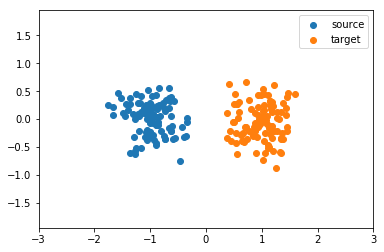

In [10]:
plt.axis("equal")
plt.axis([-3,3,-3,3])

plt.scatter(X_source[:,0], X_source[:,1], label="source")
plt.scatter(X_target[:,0], X_target[:,1], label="target")
plt.legend()

## Create the model

### Placeholders

In [11]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 2], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 2], name='ipt_target')

### Discriminator Network

In [12]:
def discriminator(x, scope): 
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope(scope):
        W1 = tf.get_variable('W1', shape=[2,10], initializer=initializer)
        b1 = tf.get_variable('b1', shape=[10], initializer=initializer)

        W2 = tf.get_variable('W2', shape=[10, 10], initializer=initializer)
        b2 = tf.get_variable('b2', shape=[10], initializer=initializer)

        W3 = tf.get_variable('W3', shape=[10, 1], initializer=initializer)
        b3 = tf.get_variable('b3', shape=[1], initializer=initializer)
        
        h1 = tf.nn.relu(tf.matmul(x, W1) + b1)
        h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
        h3 = tf.matmul(h2, W3) + b3
        #prob = tf.nn.sigmoid(h3)
    
    return h3

### Generator Network

In [13]:
def generator(x, scope):
    with tf.variable_scope(scope, reuse=None):
        W1 = tf.get_variable('W1', initializer=tf.eye(2, dtype="float32"))
        b1 = tf.get_variable('b1', shape=[2], initializer=tf.zeros_initializer())
        G_output = tf.matmul(x, W1) + b1
    
    return G_output

### Losses and solver

#### Useful functions

In [14]:
def log(tensor):
    return tf.log(tf.maximum(tensor, 1e-9))

#### Define the graph

In [15]:
with tf.variable_scope("s2t") as scope:
    D_target = discriminator(ipt_target, "discriminator")
    G_source = generator(ipt_source, "generator")
    scope.reuse_variables()
    DG_source = discriminator(G_source, "discriminator")

In [16]:
with tf.variable_scope("t2s") as scope:
    D_source = discriminator(ipt_source, "discriminator")
    G_target = generator(ipt_target, "generator")
    scope.reuse_variables()
    DG_target = discriminator(G_target, "discriminator")

In [17]:
with tf.variable_scope("s2t", reuse=True) as scope:
    cyc_target = generator(G_target, "generator")

In [18]:
with tf.variable_scope("t2s", reuse=True) as scope:
    cyc_source = generator(G_source, "generator")

#### Losses

In [19]:
lambda_cyc = 10

In [20]:
cyc_loss = tf.losses.mean_squared_error(ipt_source, cyc_source) + tf.losses.mean_squared_error(ipt_target, cyc_target)
tf.summary.scalar("cyc_loss", cyc_loss)

<tf.Tensor 'cyc_loss:0' shape=() dtype=string>

In [21]:
# D_s2t_loss = -tf.reduce_mean(log(D_target) + log(1. - DG_source))
# G_s2t_loss = -tf.reduce_mean(log(DG_source)) + lambda_cyc*cyc_loss
D_s2t_loss = tf.reduce_mean(DG_source) - tf.reduce_mean(D_target)
G_s2t_loss = -tf.reduce_mean(DG_source) + lambda_cyc*cyc_loss
tf.summary.scalar("D_s2t_loss", D_s2t_loss)
tf.summary.scalar("G_s2t_loss", G_s2t_loss)

<tf.Tensor 'G_s2t_loss:0' shape=() dtype=string>

In [22]:
D_t2s_loss = tf.reduce_mean(DG_target) - tf.reduce_mean(D_source)
G_t2s_loss = -tf.reduce_mean(DG_target) + lambda_cyc*cyc_loss
tf.summary.scalar("D_t2s_loss", D_t2s_loss)
tf.summary.scalar("G_t2s_loss", D_t2s_loss)

<tf.Tensor 'G_t2s_loss:0' shape=() dtype=string>

#### Solvers

In [23]:
model_vars = tf.trainable_variables()

D_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/discriminator')
G_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/generator')
D_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/discriminator')
G_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/generator')

In [88]:
D_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(D_s2t_loss, var_list=D_s2t_vars)
G_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(G_s2t_loss, var_list=G_s2t_vars)
D_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(D_t2s_loss, var_list=D_t2s_vars)
G_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(G_t2s_loss, var_list=G_t2s_vars)

In [89]:
clip_D_s2t = [p.assign(tf.clip_by_value(p, -1, 1)) for p in D_s2t_vars]
clip_D_t2s = [p.assign(tf.clip_by_value(p, -1, 1)) for p in D_t2s_vars]

## Run the model

In [90]:
sess = tf.InteractiveSession()

In [91]:
import shutil
shutil.rmtree('log-gaussian/')

In [92]:
summary_writer = tf.summary.FileWriter('log-gaussian/', sess.graph)

In [93]:
merged_summary = tf.summary.merge_all()

In [94]:
sess.run(tf.global_variables_initializer())
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
i = 0

In [107]:
nb_iter = 100
nb_iter_d = 10
nb_iter_g = 2
nb_samples = 40
G_s2t_loss_curr = 0.001
D_s2t_loss_curr = 0.001
G_t2s_loss_curr = 0.001
D_t2s_loss_curr = 0.001

for i in range(i, nb_iter+i):
    for k in range(nb_iter_g):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        ## Optimizing s2t
        _, G_s2t_loss_curr = sess.run([G_s2t_solver, G_s2t_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, G_t2s_loss_curr = sess.run([G_t2s_solver, G_t2s_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
        
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        ## Optimizing s2t
        _, D_s2t_loss_curr,_ = sess.run([D_s2t_solver, D_s2t_loss, clip_D_s2t], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, D_t2s_loss_curr,_ = sess.run([D_t2s_solver, D_t2s_loss, clip_D_t2s],
                                      feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
    if i % (nb_iter//5) == 0:
        cyc_loss_curr, summary = sess.run([cyc_loss, merged_summary], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
        D_s2t_loss_list.append(D_s2t_loss_curr)
        G_s2t_loss_list.append(G_s2t_loss_curr)
        D_t2s_loss_list.append(D_t2s_loss_curr)
        G_t2s_loss_list.append(G_t2s_loss_curr)
        
        summary_writer.add_summary(summary, i)
        
        print('Iter: {}'.format(i))
        print('D loss s2t: {:.4}'.format(D_s2t_loss_curr))
        print('G loss s2t: {:.4}'.format(G_s2t_loss_curr))
        print('D loss t2s: {:.4}'.format(D_t2s_loss_curr))
        print('G loss t2s: {:.4}'.format(G_t2s_loss_curr))
        print('Cycle-loss: {:.4}'.format(cyc_loss_curr))
        print()
        
summary_writer.flush()

Iter: 400
D loss s2t: -1.904
G loss s2t: 17.79
D loss t2s: 0.8391
G loss t2s: 9.283
Cycle-loss: 0.27

Iter: 420
D loss s2t: -2.251
G loss s2t: 15.31
D loss t2s: -0.2975
G loss t2s: 7.394
Cycle-loss: 0.2053

Iter: 440
D loss s2t: 0.4419
G loss s2t: 16.28
D loss t2s: -1.141
G loss t2s: 11.3
Cycle-loss: 0.2893

Iter: 460
D loss s2t: 0.08105
G loss s2t: 17.91
D loss t2s: -0.5071
G loss t2s: 11.06
Cycle-loss: 0.3768

Iter: 480
D loss s2t: -1.467
G loss s2t: 18.05
D loss t2s: 0.6108
G loss t2s: 10.42
Cycle-loss: 0.3289



## Display the results

In [108]:
X_source_trans = sess.run(G_source, feed_dict={ipt_source: X_source})
X_target_trans = sess.run(G_target, feed_dict={ipt_target: X_target})
X_source_cyc = sess.run(cyc_source, feed_dict={ipt_source: X_source})

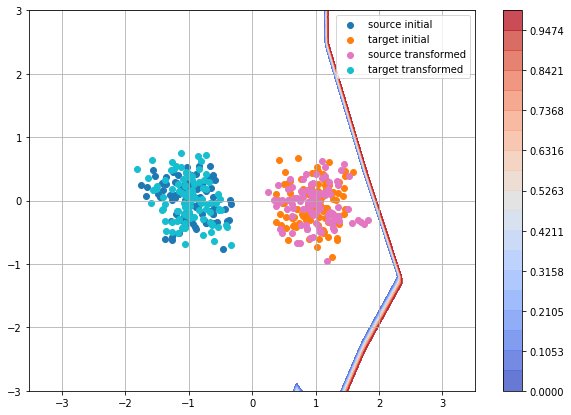

In [109]:
#plt.rcParams['figure.figsize'] = (10, 15)
plt.rcParams['figure.figsize'] = (10, 7)
plt.axes().set_aspect('equal', 'datalim')
plt.axis([-3,3,-3,3])

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

levels = np.linspace(0,1,20)
cm = plt.cm.coolwarm
Z = sess.run(D_target, feed_dict={ipt_target: np.c_[xx.ravel(), yy.ravel()]}).reshape(xx.shape)

#f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[10, 10]})

cont = plt.contourf(xx, yy, Z, levels, cmap=cm, alpha=.8)

plt.scatter(X_source[:,0], X_source[:,1], label="source initial")
plt.scatter(X_target[:,0], X_target[:,1], label="target initial")
plt.scatter(X_source_trans[:,0], X_source_trans[:,1], label="source transformed", color=colormap[6])
plt.scatter(X_target_trans[:,0], X_target_trans[:,1], label="target transformed", color=colormap[9])
#plt.scatter(X_source_cyc[:,0], X_source_cyc[:,1], label="Source cycle", color=colormap[8])

plt.legend()
#cax = f.add_axes([0.91,0.53,0.05,0.35])
# plt.colorbar(cont, cax=cax, orientation="vertical")
plt.colorbar(cont, orientation="vertical")
plt.grid()
# plt.savefig('screenshots/adda-step-77')
#a1.plot(D_loss_list, label="Discriminator loss")
#a1.plot(T_loss_list, label="Generator loss")
#a1.legend()